In [4]:
import torch as th
import numpy as np
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt

from networks.MSGNet import MSGNet
from utils.functional import get_lr
from utils.dataset_loader import SintelCropped_hf
import utils.dataset_loader as dataset_loader
from utils.utils import show_losses, save_infer_imgs, show

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


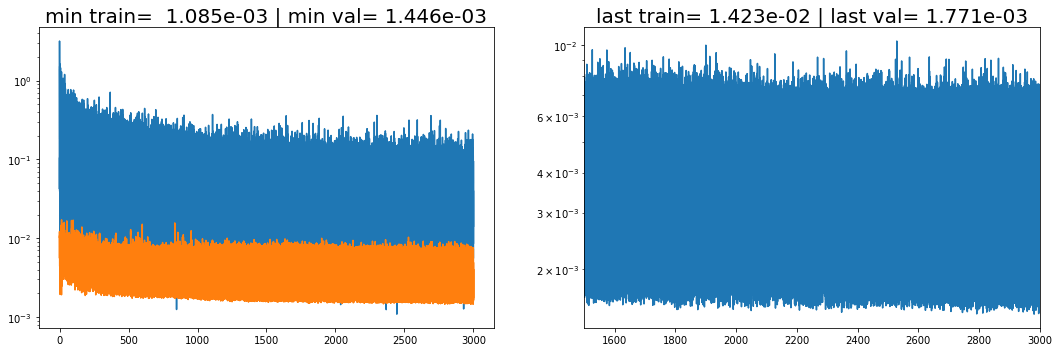

num images train =  1000
num images val =  200
train size = 5, val size = 5


In [7]:
exp_name = 'm3_imgs1000_lr0:1e-4_loss:L1+1.0E-02*TV1_p1_ordinary' 
show_losses(flag_while=False, exp_name=exp_name, log=True, only_val=True, last_epochs=1500)

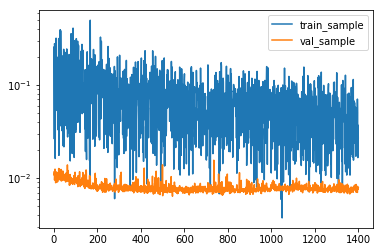

In [9]:
train_losses = np.load('./saved_models/MSGNet/'+exp_name+'/train_losses.npy')
val_losses   = np.load('./saved_models/MSGNet/'+exp_name+'/val_losses.npy')
params = np.load('./saved_models/MSGNet/'+exp_name+'/exp_params.npy').item()
len(train_losses)
step1 = 100
step2 = 1500
num_batches_train, num_batches_val = params['train_num_batches'], params['val_num_batches']
plt.semilogy(train_losses[::num_batches_train][step1:step2], label='train_sample')
plt.semilogy(val_losses[::num_batches_val][step1:step2], label='val_sample')
plt.legend();

In [10]:
net = MSGNet(m=params['m'], 
             num_channels=params['num_channels'], 
             num_channels_y1=params['num_channels_y1'], 
             num_channels_d1=params['num_channels_d1'], 
             training_type=params['training_type'], 
             nnl_type=params['nnl_type'])

In [11]:
saved_epoch = 3000 # the index of saved model
path2state = './saved_models/MSGNet/'+exp_name+'/state_{:04d}.pth'.format(saved_epoch)
state = th.load(path2state, map_location=th.device('cpu'))
net.load_state_dict(state['model_state_dict']);

In [13]:
m=3
sintel = dataset_loader.Sintel(get_name=True, size=(432,1024), m=m, mode='val')
img_ind = 1000 # one of images from the validation.
image, depth, name = sintel[img_ind] 
depth_lr = get_lr(depth, m=m, do_filtering=False, mode='gaus', sigma=1)

res = net.do_inference(image, depth, mode='gaus', sigma=1, do_filtering=False)
res[res < depth.min()] = depth.min()
res[res > depth.max()] = depth.max() # hand-made post-processing, gives visually better results.

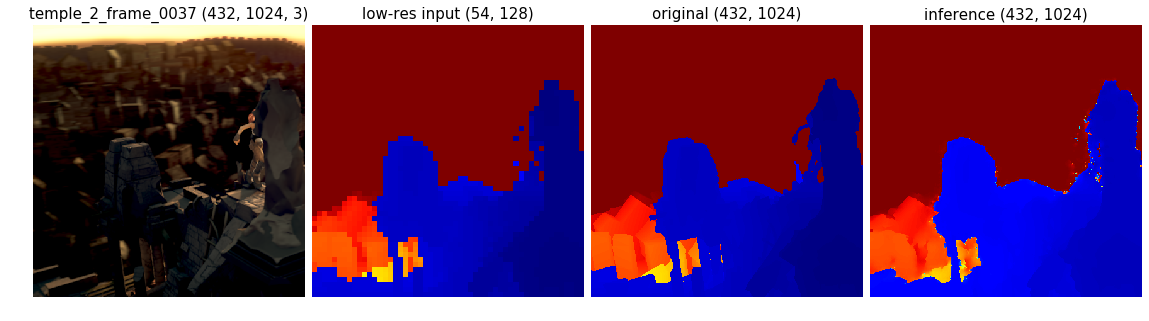

In [14]:
crop_ = 54
crops = [crop_*(2**m), crop_, crop_*(2**m), crop_*(2**m)]
images = [image, depth_lr, depth, res]
titles = [name+' {}'.format(image.shape), 'low-res input {}'.format(depth_lr.shape), 
          'original {}'.format(depth.shape), 'inference {}'.format(res.shape)]
show(images=images, titles=titles, crops=crops)

In [15]:
# USE THIS LINE ONLY IF YOU WANT TO SAVE INFERENCE RESULTS PER EACH SAVED EPOCH

save_infer_imgs(exp_name=exp_name, net=net, rgb=image, depth=depth, crop=432)

1it [00:01,  1.24s/it]
